In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.inspection import permutation_importance
import shap

Load data and model

In [14]:
df_lgbm = pd.read_parquet(os.path.join('..', 'data', 'modelling', 'lgbm.parquet'))
df_lgbm.sort_index(inplace=True)
df_X = df_lgbm.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
model = load(os.path.join('..', 'models', 'lgbm_model.joblib'))


Get feature names

In [15]:
features = df_X.columns
features = np.array([f.replace('_', ' ') for f in features])

xg predictions. First have to fit to training data

In [16]:
df_lgbm['xg'] = model.predict_proba(df_X)[:, 1]

Get a datafrane if the uncalibrated/ calibrated probabilities for each of the three models

In [17]:
models = model.calibrated_classifiers_
estimators = [model.estimator for model in models]
probabilities = []
for i in range(3):
    probabilities.append(estimators[i].predict_proba(df_X)[:, 1])
    probabilities.append(models[i].predict_proba(df_X)[:, 1])
df_probabilities = pd.DataFrame(np.vstack(probabilities).T, columns=['uncalibrated0', 'calibrated0',
                                                                     'uncalibrated1', 'calibrated1',
                                                                     'uncalibrated2', 'calibrated2'])
df_probabilities['calibrated'] = model.predict_proba(df_X)[:, 1]

Shap values from shap package (estimate as probabilites rather than log odds deviation from bias).
Done in loop for the estimators in the calibrated classifier

In [18]:
# this takes a while, but calculates the contributions as probabilities
# https://github.com/slundberg/shap/issues/963
sample = data=df_X.sample(500).astype(np.float32)
contributions = []
for estimator in estimators:
    explainer = shap.TreeExplainer(estimator, data=sample, model_output='probability')
    shap_values_probability = explainer.shap_values(df_X)
    bias = explainer.expected_value
    df_contributions_probability = pd.DataFrame(shap_values_probability, columns=features)
    df_contributions_probability['bias'] = bias
    contributions.append(df_contributions_probability)

100%|===================| 128158/128369 [09:26<00:00]        

Scale the uncalibrated contributions to sum to the calibrated predicted probability

In [19]:
scaled_contributions = []
for i in range(3):
    scaled = (contributions[i]
              .divide(df_probabilities[f'uncalibrated{i}'], axis=0)
              .multiply(df_probabilities[f'calibrated{i}'], axis=0))
    scaled_contributions.append(scaled)   
df_scaled_contributions = (scaled_contributions[0] + scaled_contributions[1] + scaled_contributions[2])/3.

Remove a few where the scaled contributions don't match the actual xg

In [20]:
df_base = df_lgbm[['match_id', 'wyscout_id', 'statsbomb_id', 'xg']]
print(df_scaled_contributions.shape)
print(df_base.shape)

(128369, 26)
(128369, 4)


Where scaled contributions not within 5 decimal places of the Xg value set to missing (some rounding errors)

In [21]:
df_scaled_contributions.reset_index(drop=True, inplace=True)
df_base.reset_index(drop=True, inplace=True)

In [22]:
mask_contributions_not_equal = ((df_scaled_contributions.sum(axis=1) - df_base.xg).abs().round(5) > 0)
df_scaled_contributions[mask_contributions_not_equal] = np.nan

Return a dataframe with the contirubtions, match and event ids, and the contributions and xg

In [23]:
df_base = df_base.merge(df_scaled_contributions,
                        left_index=True,
                        right_index=True,
                        how='left',
                        validate='1:1')

In [24]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128369 entries, 0 to 128368
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   match_id             128369 non-null  int64  
 1   wyscout_id           42808 non-null   float64
 2   statsbomb_id         85561 non-null   object 
 3   xg                   128369 non-null  float64
 4   shot type name       128204 non-null  float64
 5   x                    128204 non-null  float64
 6   y                    128204 non-null  float64
 7   counter attack       128204 non-null  float64
 8   fast break           128204 non-null  float64
 9   strong foot          128204 non-null  float64
 10  body part name       128204 non-null  float64
 11  assist type          128204 non-null  float64
 12  pass end y           128204 non-null  float64
 13  pass end x           128204 non-null  float64
 14  pass switch          128204 non-null  float64
 15  pass cross       

Save the dataframe

In [25]:
df_base.to_parquet(os.path.join('..', 'data', 'modelling', 'xg_shap.parquet'))

Use Shap to plot a contribution

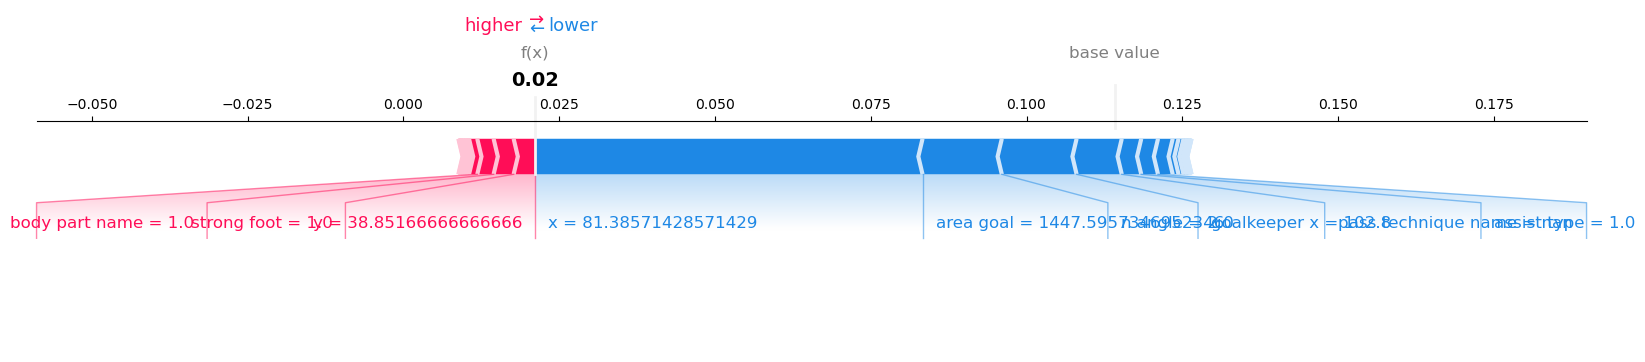

In [26]:
idx=2
shap.force_plot(df_scaled_contributions.iloc[idx, -1], 
                df_scaled_contributions.iloc[idx, :-1].values,
                features=df_X.iloc[idx].values,
                feature_names=features, matplotlib=True, show=False)
fig = plt.gcf()
fig.savefig(os.path.join('..', 'figures', '08_shap_example.png'), bbox_inches = 'tight', pad_inches = 0.2)